In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline

import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Case study - zbiór `Boston House Dataset`

In [2]:
from sklearn import datasets
boston = datasets.load_boston()

In [3]:
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

## Model prostej regresji liniowej
1. Interesuje nas zależność wielkości ceny domu od średniej liczby pokoi w domu (zmienne `PRICE` i `RM`). Określ zmienną zależną i niezależną, a następnie:

      a) Narysuj wykres rozproszenia tych zmiennych. 
      
      b) Czy zmienne te są zależne? 
      
      c) Oblicz dla nich współczynnik korelacji Pearsona. 


2. Podziel dane na część treningową i na część testową w stosunku 7:3.


3. Wyznacz funkcję regresji wielkości ceny domu względem średniej liczby pokoi. Narysuj ją na wykresie rozproszenia.


4. Zweryfikuj dopasowanie modelu:

    a) Czy istnieje związek pomiędzy zmienną zależną a niezależną?
    
    b) Czy wyraz wolny jest istotny w modelu?
    
    c) Oblicz i zinterpretuj wartość współczynnika determinacji $R^2$.
    
    d) Sprawdź, czy spełnione jest założenie o rozkładzie normalnym reszt.
    
    e) Zweryfikuj dopasowanie modelu, sporządź wykresy diagnostyczne: wykres wartości przewidywanych względem prawdziwych, wykres residuów względem wartości dopasowanych.
    
    f) Wyznacz i porównaj jakość dopasowania i predykcji za pomocą różnych miar (np. MSE, MAE, $R^2$).

## Model wielorakiej regresji liniowej

5. Wyznacz model liniowy najlepiej opisujący zależność zależność wielkości ceny domu od pozostałych dostępnych zmiennych:

    a) Czy istnieje związek pomiędzy zmienną zależną a którąkolwiek ze zmiennych niezależnych?
    
    b) Dla których zmiennych niezależnych Xj, j=1,...,10 można odrzucić hipotezę zerową  H0: βj = 0?
    
    c) Biorąc pod uwagę odpowiedź na poprzednie pytanie, wyznacz mniejszy model w oparciu tylko o zmienne, które faktycznie mają istotny wpływ na wielkość sprzedaży.
    
    d) Porównaj dopasowanie obu modeli (większego i mniejszego), sporządź wykresy diagnostyczne.
    
    e) Wyznacz i porównaj jakość dopasowania i predykcji dla modelu mniejszego i większego.

## Regularyzacja

6. Zastosuj regularyzację

    a) grzbietową
    
    b) Lasso


## Model regresji wielomiaowej

7. Dopasuj model regresji wielomianowej:
        
    a) Znajdź optymalny stopień wielomianu.
    
    b) Zweryfikuj dopasowanie modelu, sporządź wykresy diagnostyczne.
    
    c) Zastosuj regularyzację znajdując najlepszy parametr $\alpha$.

## Podsumowanie

8. Dokonaj porównania dopasowanych powyżej modeli regresji pod względem błędu dopasowania i błędu predykcji (dane końcowe przedstaw za pomocą tabeli). 
    
**Pamiętaj o graficznej ewaluacji modeli regresji!!!**

In [34]:
boston_full = pd.DataFrame(boston['data'], columns=boston['feature_names'])
boston_full['PRICE'] = boston['target']
print(boston_full)

        CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0    0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1    0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2    0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3    0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4    0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
501  0.06263   0.0  11.93   0.0  0.573  6.593  69.1  2.4786  1.0  273.0   
502  0.04527   0.0  11.93   0.0  0.573  6.120  76.7  2.2875  1.0  273.0   
503  0.06076   0.0  11.93   0.0  0.573  6.976  91.0  2.1675  1.0  273.0   
504  0.10959   0.0  11.93   0.0  0.573  6.794  89.3  2.3889  1.0  273.0   
505  0.04741   0.0  11.93   0.0  0.573  6.030  80.8  2.5050  1.0  273.0   

     PTRATIO       B  LSTAT  PRICE  
0       15.3  396.90   4.98   24.0  
1       17.8  396.90   9.

In [46]:
X, y = pd.DataFrame(boston['data'], columns=boston['feature_names']), boston['target']
y

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 18.7, 16. , 22.2, 25. , 33. , 23.5,
       19.4, 22. , 17.4, 20.9, 24.2, 21.7, 22.8, 23.4, 24.1, 21.4, 20. ,
       20.8, 21.2, 20.3, 28. , 23.9, 24.8, 22.9, 23.9, 26.6, 22.5, 22.2,
       23.6, 28.7, 22.6, 22. , 22.9, 25. , 20.6, 28.4, 21.4, 38.7, 43.8,
       33.2, 27.5, 26.5, 18.6, 19.3, 20.1, 19.5, 19.5, 20.4, 19.8, 19.4,
       21.7, 22.8, 18.8, 18.7, 18.5, 18.3, 21.2, 19.2, 20.4, 19.3, 22. ,
       20.3, 20.5, 17.3, 18.8, 21.4, 15.7, 16.2, 18. , 14.3, 19.2, 19.6,
       23. , 18.4, 15.6, 18.1, 17.4, 17.1, 13.3, 17.8, 14. , 14.4, 13.4,
       15.6, 11.8, 13.8, 15.6, 14.6, 17.8, 15.4, 21

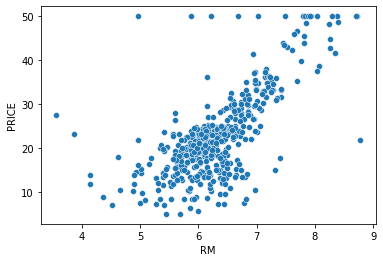

0.6953599470715393

In [47]:
#prosta regresja
#1
#PRICE - zm. zależna
#RM - zm .niezależna
x_small = boston_full.PRICE
y_small = boston_full.RM
sns.scatterplot(y_small, x_small)
plt.show()
np.corrcoef(x_small, y_small)[0,1]
#zmienna są zależne liniowo

In [49]:
#2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
y_train

array([35.2, 25. , 36.2, 16.1, 10.9, 36.4, 25. , 20.1, 16.8, 23.7, 42.3,
       17.9, 12.7, 50. , 18.4, 33.4, 22.9, 14.6, 29.9, 22.6, 22.5, 29. ,
       50. , 37.9, 21.4, 29.4, 20.3, 23. , 30.1, 21.7, 36.5, 25. , 24.5,
       37.3, 33.8, 24.7, 32.7, 23.1, 25.1, 21.7, 13.4, 24.8, 12.7, 11.8,
        8.3, 20.2, 41.3, 23.2, 23.1, 24.3, 19.3, 10.8, 18.6, 29. , 23.9,
       19.5, 13.1, 31.7, 21. , 18.2, 21. , 21.2, 14.1, 33.2, 13.8, 19.9,
       21.7, 20.6, 21.2, 13.6, 18.9, 18. , 24.1, 28.7, 23.4, 15.2, 23.6,
       13.8, 11.7, 16.3, 50. , 13.5, 50. , 31.5, 22.6, 12.1, 21.7, 14.1,
       22.4, 13.4, 33.1, 20.6,  8.3, 36.2,  6.3, 21.5, 23.3, 24. , 19.1,
       29.6, 27.9, 16.2,  9.5, 24.6, 15.6,  8.1, 15.3, 19. , 22. , 28. ,
       19.2, 14.5,  9.7, 30.7, 20.6, 16. , 19.8, 17.8, 21.2, 28.7, 41.7,
        7.2, 13.4, 17.7, 26.7, 23.8, 21.8, 27.1, 18.3,  5. , 10.4, 18.5,
       17.4, 28.6, 50. , 14.2, 31.2,  8.4, 23. , 35.1, 23.9, 20.3, 46.7,
       15. , 18.4, 17.8, 22.5, 18.8, 20.9, 50. , 29

[9.74062315]
-38.74191599333736


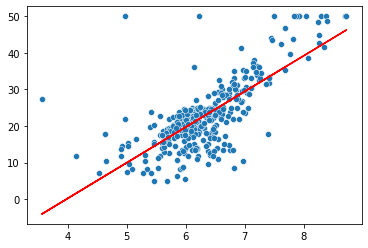

In [52]:
#3 scikit
x_train = np.array(X_train['RM'])
x_train_data = x_train.reshape(-1,1)
x_test = np.array(X_test['RM'])
x_test_data = x_test.reshape(-1,1)
sns.scatterplot(x_train,y_train)
lm1 = LinearRegression()
lm1.fit(X = x_train_data, y = y_train)
print(lm1.coef_)
print(lm1.intercept_)
plt.plot(x_train,lm1.predict(x_train_data),color = 'red')

In [54]:
#statmodels
x_with_const = sm.add_constant(x_train, prepend=True, has_constant='skip')
x_test_with_const =  sm.add_constant(x_test, prepend=True, has_constant='skip')

model = sm.OLS(endog=y_train, exog=x_with_const)
fitted_model = model.fit()

In [61]:
#4
print(fitted_model.summary())
#a
print(fitted_model.pvalues[1])
#b
print(fitted_model.pvalues[0])
#c
print(fitted_model.rsquared)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     437.0
Date:                Sat, 18 Jun 2022   Prob (F-statistic):           1.15e-63
Time:                        14:18:13   Log-Likelihood:                -1147.4
No. Observations:                 354   AIC:                             2299.
Df Residuals:                     352   BIC:                             2307.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -38.7419      2.960    -13.086      0.0

1.5904206606110176e-24
0.0


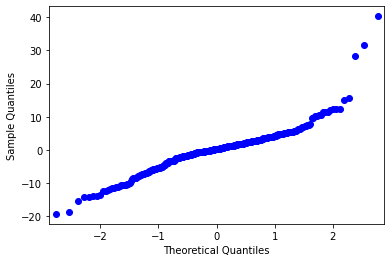

In [67]:
#d
print(stats.normaltest(fitted_model.resid).pvalue)
print(stats.jarque_bera(fitted_model.resid)[1])
sm.qqplot(fitted_model.resid)
plt.show()

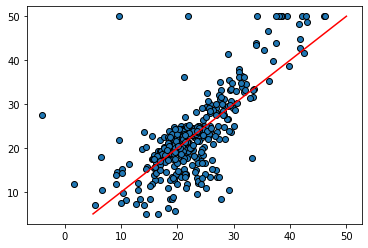

In [75]:
#e
xrange = np.linspace(y_train.min(), y_train.max(), 100)
plt.scatter(lm1.predict(x_train_data), y_train, edgecolors="k")
plt.plot(xrange, xrange, color='red')

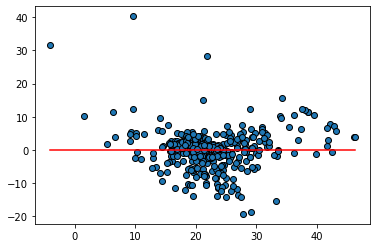

In [79]:
xrange = np.linspace(lm1.predict(x_train_data).min(), lm1.predict(x_train_data).max(), 100)
plt.scatter(lm1.predict(x_train_data), fitted_model.resid, edgecolors="k")
plt.plot(xrange, np.repeat(0,len(xrange)), color='red')

In [84]:
#f
#dopasowania
print(lm1.score(x_train_data,y_train))
print(metrics.mean_squared_error(y_train,lm1.predict(x_train_data)))
print(metrics.median_absolute_error(y_train,lm1.predict(x_train_data)))
#predykcje
print(lm1.score(x_test_data,y_test))
print(metrics.mean_squared_error(y_test,lm1.predict(x_test_data)))
print(metrics.median_absolute_error(y_test,lm1.predict(x_test_data)))

0.5538772473809861
38.27152901182499
2.673881525341125
0.2986146751413239
56.69163733537954
3.2955962461082073


In [85]:
#regresja wielokrotna
#statmodels
X_with_const = sm.add_constant(X_train, prepend=True, has_constant='skip')
X_test_with_const =  sm.add_constant(X_test, prepend=True, has_constant='skip')

model = sm.OLS(endog=y_train, exog=X_with_const)
fitted_model = model.fit()


In [86]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     85.00
Date:                Sat, 18 Jun 2022   Prob (F-statistic):           2.44e-98
Time:                        14:49:17   Log-Likelihood:                -1034.2
No. Observations:                 354   AIC:                             2096.
Df Residuals:                     340   BIC:                             2151.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.9813      6.043      4.796      0.000      17.094      40.868
CRIM          -0.1010      0.035     -2.909      0.004      -0.169      -0.033
ZN             0.0400      0.016      2.551      0.011       0.009       0.071
INDUS          0.0754      0.072      1.045      0.297      -0.067       0.217
CHAS           0.2646      1.063      0.249      0.804      -1.826       2.355
NOX          -14.3409      4.595     -3.121      0.002     -23.380      -5.302
RM             4.8332      0.485      9.971      0.000       3.880       5.787
AGE           -0.0074      0.015     -0.488      0.626      -0.037       0.023
DIS           -1.3267      0.226     -5.879      0.000      -1.771      -0.883
RAD            0.2735      0.075      3.660      0.000       0.126       0.420
TAX           -0.0130      0.004     -3.059      0.002      -0.021      -0.005
PTRATIO       -0.9566      0.150     -6.372      0.000      -1.252      -0.661
B              0.0064      0.003      1.965      0.050   -7.31e-06       0.013
LSTAT         -0.4866      0.061     -8.032      0.000      -0.606      -0.367
==============================================================================
Omnibus:                      164.467   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1012.790
Skew:                           1.865   Prob(JB):                    1.19e-220
Kurtosis:                      10.399   Cond. No.                     1.55e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [87]:
#a
fitted_model.f_pvalue

2.4421048253055118e-98

In [88]:
#b
features1 = np.array(model.exog_names)[fitted_model.pvalues < 0.05]
features1

array(['const', 'CRIM', 'ZN', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO',
       'LSTAT'], dtype='<U7')

In [89]:
#c
model2 = sm.OLS(endog=y_train, exog=X_with_const[features1])
fitted_model2 = model2.fit()
fitted_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     121.8
Date:                Sat, 18 Jun 2022   Prob (F-statistic):          2.47e-101
Time:                        14:59:15   Log-Likelihood:                -1036.8
No. Observations:                 354   AIC:                             2094.
Df Residuals:                     344   BIC:                             2132.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.2530      5.718      5.640      0.000      21.006      43.500
CRIM          -0.1043      0.035     -3.008      0.003      -0.173      -0.036
ZN             0.0394      0.016      2.537      0.012       0.009       0.070
NOX          -13.9652      4.260     -3.278      0.001     -22.344      -5.586
RM             4.6506      0.469      9.918      0.000       3.728       5.573
DIS           -1.3625      0.213     -6.408      0.000      -1.781      -0.944
RAD            0.2353      0.070      3.368      0.001       0.098       0.373
TAX           -0.0113      0.004     -3.058      0.002      -0.019      -0.004
PTRATIO       -0.9310      0.148     -6.286      0.000      -1.222      -0.640
LSTAT         -0.5126      0.056     -9.216      0.000      -0.622      -0.403
==============================================================================
Omnibus:                      157.411   Durbin-Watson:                   2.156
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              912.527
Skew:                           1.791   Prob(JB):                    7.03e-199
Kurtosis:                      10.002   Cond. No.                     1.14e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""